# Analysis of MPI-IO wite peformance: benchio

Results of benchio MPI-IO write performance on a range of systems

## Setup and helper functions

Import the required Python modules

In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")

In [28]:
import sys
sys.path.append('../../../python-modules')

In [29]:
from synthanalysis import benchio

Small funtion to read data from a list of files and create a pandas dataframe with the performance data

In [30]:
def create_df(filelist, cpn):
    df_list = []
    for file in filelist:
        df_list.extend(benchio.getperf(file, cpn))
    return pd.DataFrame(df_list)   

## Read data

In [31]:
resdir = '../results/ARCHER'
files = benchio.get_filelist(resdir, "benchio_")
archer_res = create_df(files, 24)

In [32]:
resdir = '../results/Cirrus'
files = benchio.get_filelist(resdir, "benchio_")
cirrus_res = create_df(files, 36)

In [33]:
resdir = '../results/Thomas'
files = benchio.get_filelist(resdir, "benchio_")
thomas_res = create_df(files, 24)

In [34]:
resdir = '../results/CSD3Skylake'
files = benchio.get_filelist(resdir, "benchio_")
csd3_res = create_df(files, 32)

## Analyse results

### ARCHER

In [35]:
archer_writers, archer_clients, archer_maxwrite = benchio.get_perf_stats(archer_res, -1, 256, 'max', writestats=True)
archer_writers, archer_clients, archer_medwrite = benchio.get_perf_stats(archer_res, -1, 256, 'median')

                                           Write                              \
                                             min        median           max   
Writers Clients Striping LocalSize                                             
24      1       -1       256          609.242149    640.324503    661.667327   
48      2       -1       256         1153.616446   1263.887274   1310.712323   
96      4       -1       256         1818.127449   2167.191612   2270.360488   
192     8       -1       256         2280.798789   3720.000888   3790.923948   
384     16      -1       256         2108.893877   4969.245834   5359.534893   
768     32      -1       256         2525.958656   5358.865119   5919.019116   
1536    64      -1       256         3436.416729   6919.354665   8473.660398   
3072    128     -1       256         5843.138337  10533.143992  11320.886446   
6144    256     -1       256        10708.537982  11304.231941  11529.934143   
12288   512     -1       256         452

### Cirrus

In [36]:
cirrus_writers, cirrus_clients, cirrus_maxwrite = benchio.get_perf_stats(cirrus_res, -1, 256, 'max', writestats=True)
cirrus_writers, cirrus_clients, cirrus_medwrite = benchio.get_perf_stats(cirrus_res, -1, 256, 'median')

                                          Write                            \
                                            min       median          max   
Writers Clients Striping LocalSize                                          
36      1       -1       256         548.857362   556.490015   572.148949   
72      2       -1       256         882.584048   907.302454   915.846547   
144     4       -1       256        1437.682851  1466.758103  1506.970847   
288     8       -1       256        3094.565797  3199.662248  3240.886716   
576     16      -1       256        5648.993752  6883.934438  6990.985356   
1152    32      -1       256        6225.530317  7114.246634  7685.589335   
2304    64      -1       256        5612.660332  6912.794964  7474.470739   
4608    128     -1       256        6445.256527  6856.622290  7617.000845   
9216    256     -1       256        5671.240679  5671.240679  5671.240679   

                                                Count  
                   

In [37]:
thomas_writers, thomas_clients, thomas_maxwrite = benchio.get_perf_stats(thomas_res, -1, 256, 'max', writestats=True)
thomas_writers, thomas_clients, thomas_medwrite = benchio.get_perf_stats(thomas_res, -1, 256, 'median')

                                          Write                            \
                                            min       median          max   
Writers Clients Striping LocalSize                                          
24      1       -1       256         607.913939   617.627687   652.206613   
48      2       -1       256         237.048981   664.594128   991.562527   
96      4       -1       256        1805.893479  2018.994681  2138.186989   
192     8       -1       256        2809.554912  3570.741620  3903.458093   
384     16      -1       256        1802.693062  2177.757686  2515.184772   

                                                Count  
                                           mean   sum  
Writers Clients Striping LocalSize                     
24      1       -1       256         620.963217    10  
48      2       -1       256         655.196124    10  
96      4       -1       256        1990.098498    10  
192     8       -1       256        3513.616239

### Peta4-Skylake

In [38]:
csd3_writers, csd3_clients, csd3_maxwrite = benchio.get_perf_stats(csd3_res, -1, 256, 'max', writestats=True)
csd3_writers, csd3_clients, csd3_medwrite = benchio.get_perf_stats(csd3_res, -1, 256, 'median')
csd3_writers.extend([2048,4096,8192])
csd3_clients.extend([64,128,256])
csd3_maxwrite.extend([7551.430538,7386.463665,7255.646114])
csd3_medwrite.extend([6315.741808,6165.406991,6666.272001])
print(csd3_writers)

                                          Write                            \
                                            min       median          max   
Writers Clients Striping LocalSize                                          
32      1       -1       256         478.419608   498.712175   558.110451   
64      2       -1       256         599.035827   636.006058   642.350794   
128     4       -1       256        1670.827966  1938.053055  2006.403979   
256     8       -1       256        3570.643235  3743.316042  3839.521461   
512     16      -1       256        6090.346281  6441.059608  6589.572467   
1024    32      -1       256        5748.729080  6351.363864  6722.794248   

                                                Count  
                                           mean   sum  
Writers Clients Striping LocalSize                     
32      1       -1       256         502.118539    10  
64      2       -1       256         632.220207    10  
128     4       -1       2

## Comparison

Compare maximum and median write performance for maximum striping across all systems.

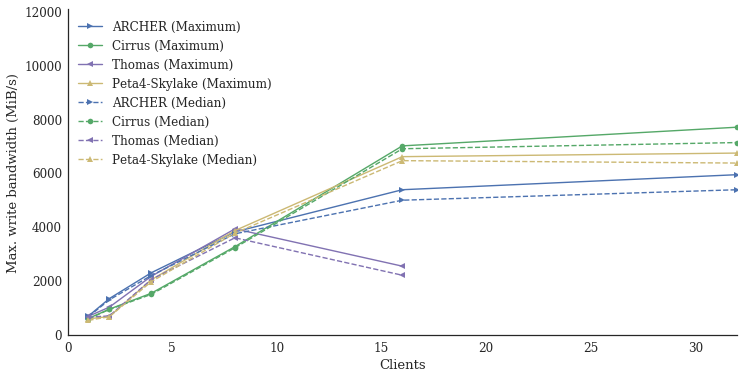

In [39]:
fig, ax = plt.subplots()
pal = sns.color_palette()
cols = pal.as_hex()
plt.plot(archer_clients, archer_maxwrite, '>-', color=cols[0], label='ARCHER (Maximum)')
plt.plot(cirrus_clients, cirrus_maxwrite, 'o-', color=cols[1], label='Cirrus (Maximum)')
plt.plot(thomas_clients, thomas_maxwrite, '<-', color=cols[3], label='Thomas (Maximum)')
plt.plot(csd3_clients, csd3_maxwrite, '^-', color=cols[4], label='Peta4-Skylake (Maximum)')
plt.plot(archer_clients, archer_medwrite, '>--', color=cols[0], label='ARCHER (Median)')
plt.plot(cirrus_clients, cirrus_medwrite, 'o--', color=cols[1], label='Cirrus (Median)')
plt.plot(thomas_clients, thomas_medwrite, '<--', color=cols[3], label='Thomas (Median)')
plt.plot(csd3_clients, csd3_medwrite, '^--', color=cols[4], label='Peta4-Skylake (Median)')
plt.xlabel('Clients')
plt.ylabel('Max. write bandwidth (MiB/s)')
plt.xlim(0,32)
plt.legend(loc='best')
sns.despine()
plt.savefig('benchio_write_bw_small.png', dpi=300)

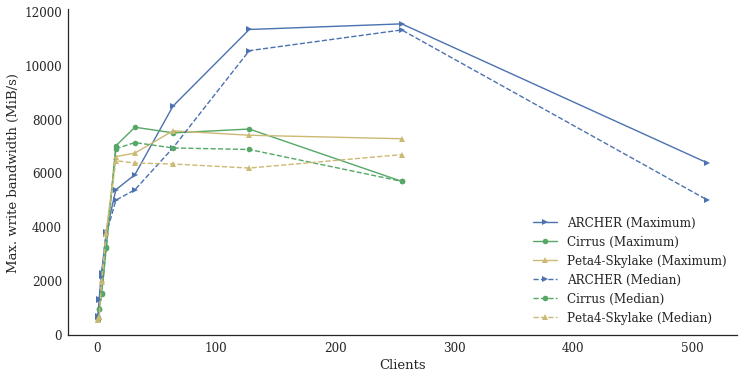

In [40]:
fig, ax = plt.subplots()
pal = sns.color_palette()
cols = pal.as_hex()
plt.plot(archer_clients, archer_maxwrite, '>-', color=cols[0], label='ARCHER (Maximum)')
plt.plot(cirrus_clients, cirrus_maxwrite, 'o-', color=cols[1], label='Cirrus (Maximum)')
plt.plot(csd3_clients, csd3_maxwrite, '^-', color=cols[4], label='Peta4-Skylake (Maximum)')
plt.plot(archer_clients, archer_medwrite, '>--', color=cols[0], label='ARCHER (Median)')
plt.plot(cirrus_clients, cirrus_medwrite, 'o--', color=cols[1], label='Cirrus (Median)')
plt.plot(csd3_clients, csd3_medwrite, '^--', color=cols[4], label='Peta4-Skylake (Median)')
plt.xlabel('Clients')
plt.ylabel('Max. write bandwidth (MiB/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('benchio_write_bw_large.png', dpi=300)